In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| include: false
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
import torch

from collections import Counter
from completeformer.models import Completeformer
from datasets import load_dataset
from transformers import AutoTokenizer
from x_transformers.autoregressive_wrapper import top_p

2022-08-16 16:58:47.625138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
tokenizer_name = "ncoop57/completeformer-tokenizer"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
tokenizer.add_special_tokens(
    {
        "mask_token": "<MASK>",
        "pad_token": "<PAD>",
        "bos_token": "<BOS>",
        "eos_token": "<EOS>",
    }
)
tokenizer.add_tokens(["<TAB>"])

1

In [ ]:
import random

dataset = load_dataset("semeru/completeformer-masked", use_auth_token=True)
trn_dataset, val_dataset, tst_dataset = dataset["train"], dataset["validation"], dataset["test"]

percentage = 0.1
n = int(len(tst_dataset) * percentage)
selection = random.sample(range(len(tst_dataset)), n)
trn_dataset = trn_dataset.select(selection)
val_dataset = val_dataset.select(selection)
tst_dataset = tst_dataset.select(selection)

No config specified, defaulting to: completeformer-masked/all
Reusing dataset completeformer-masked (/home/jovyan/.cache/huggingface/datasets/semeru___completeformer-masked/all/1.1.0/d5935d01f9f5ec075651056b9b6acd658a2b66d396fd8c8bec6cddebd64c3d69)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
def tokenize_dataset(examples, size):
    # print(examples[f"{size}_target"])
    tokenized_inputs = tokenizer(
        examples[f"{size}_target"],
    )["input_ids"]
    examples[f"{size}_target_ids"] = tokenized_inputs
    return examples


trn_dataset = trn_dataset.map(lambda x: tokenize_dataset(x, "simple"), batched=True)
trn_dataset = trn_dataset.map(lambda x: tokenize_dataset(x, "medium"), batched=True)
trn_dataset = trn_dataset.map(lambda x: tokenize_dataset(x, "complex"), batched=True)

tst_dataset = tst_dataset.map(lambda x: tokenize_dataset(x, "simple"), batched=True)
tst_dataset = tst_dataset.map(lambda x: tokenize_dataset(x, "medium"), batched=True)
tst_dataset = tst_dataset.map(lambda x: tokenize_dataset(x, "complex"), batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
trn_simple_tokens = Counter(tokenizer.get_vocab().values())
trn_medium_tokens = Counter(tokenizer.get_vocab().values())
trn_complex_tokens = Counter(tokenizer.get_vocab().values())

tst_simple_tokens = Counter(tokenizer.get_vocab().values())
tst_medium_tokens = Counter(tokenizer.get_vocab().values())
tst_complex_tokens = Counter(tokenizer.get_vocab().values())

In [ ]:
for row in trn_dataset:
    trn_simple_tokens.update(row["simple_target_ids"])
    trn_medium_tokens.update(row["medium_target_ids"])
    trn_complex_tokens.update(row["complex_target_ids"])

In [ ]:
for row in tst_dataset:
    tst_simple_tokens.update(row["simple_target_ids"])
    tst_medium_tokens.update(row["medium_target_ids"])
    tst_complex_tokens.update(row["complex_target_ids"])

In [ ]:
trn_simple_tokens.most_common(10)

[(50004, 25219),
 (63, 6947),
 (14, 5508),
 (9, 5005),
 (221, 4354),
 (8, 3566),
 (12, 2548),
 (272, 1433),
 (29, 1421),
 (261, 1118)]

In [ ]:
from scipy.spatial import distance

distance.jensenshannon([1.0, 0.0, 0.0], [0.0, 1.0, 0.0], 2.0)

1.0

In [ ]:
simple_medium = distance.jensenshannon(list(trn_simple_tokens.values()), list(trn_medium_tokens.values()))
simple_complex = distance.jensenshannon(list(trn_simple_tokens.values()), list(trn_complex_tokens.values()))
medium_complex = distance.jensenshannon(list(trn_medium_tokens.values()), list(trn_complex_tokens.values()))

print("Training JS Distance")
print(f"Simple-Medium: {simple_medium}")
print(f"Simple-Complex: {simple_complex}")
print(f"Medium-Complex: {medium_complex}")

Training JS Divergence
Simple-Medium: 0.08841371204087362
Simple-Complex: 0.18182179801038995
Medium-Complex: 0.11629754530885716


In [ ]:
simple_medium = distance.jensenshannon(list(tst_simple_tokens.values()), list(tst_medium_tokens.values()))
simple_complex = distance.jensenshannon(list(tst_simple_tokens.values()), list(tst_complex_tokens.values()))
medium_complex = distance.jensenshannon(list(tst_medium_tokens.values()), list(tst_complex_tokens.values()))

print("Testing JS Distance")
print(f"Simple-Medium: {simple_medium}")
print(f"Simple-Complex: {simple_complex}")
print(f"Medium-Complex: {medium_complex}")

Testing JS Divergence
Simple-Medium: 0.08876907151668939
Simple-Complex: 0.18313409960478524
Medium-Complex: 0.11707732275489735


In [ ]:
simple_js = distance.jensenshannon(list(trn_simple_tokens.values()), list(tst_simple_tokens.values()))
medium_js = distance.jensenshannon(list(trn_medium_tokens.values()), list(tst_medium_tokens.values()))
complex_js = distance.jensenshannon(list(trn_complex_tokens.values()), list(tst_complex_tokens.values()))

simple_medium_js = distance.jensenshannon(list(trn_simple_tokens.values()), list(tst_medium_tokens.values()))
simple_complex_js = distance.jensenshannon(list(trn_simple_tokens.values()), list(tst_complex_tokens.values()))
medium_complex_js = distance.jensenshannon(list(trn_medium_tokens.values()), list(tst_complex_tokens.values()))

print("Training-Testing JS Distance")
print(f"Simple JS: {simple_js}")
print(f"Medium JS: {medium_js}")
print(f"Complex JS: {complex_js}")

print("Training-Testing JS Distance")
print(f"Simple-Medium JS: {simple_medium_js}")
print(f"Simple-Complex JS: {simple_complex_js}")
print(f"Medium-Complex JS: {medium_complex_js}")

Training-Testing JS Divergence
Simple JS: 0.10300740545304153
Medium JS: 0.10342925625480277
Complex JS: 0.10043082418389268
Training-Testing JS Divergence
Simple-Medium JS: 0.12752883526692013
Simple-Complex JS: 0.19861487569975506
Medium-Complex JS: 0.1456930020589297


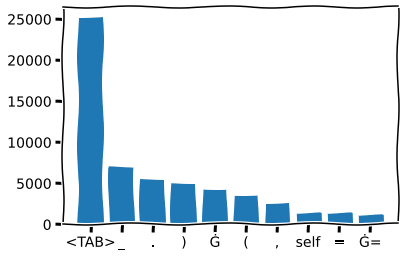

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
keys, values = zip(*trn_simple_tokens.most_common(10))
plt.bar([tokenizer.convert_ids_to_tokens(k) for k in keys], values)
plt.show()

f.savefig("trn_simple_token_freq.pdf", bbox_inches='tight')

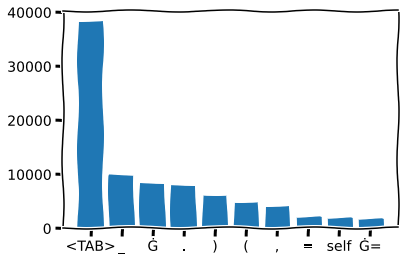

In [ ]:
keys, values = zip(*trn_medium_tokens.most_common(10))
plt.bar([tokenizer.convert_ids_to_tokens(k) for k in keys], values)
plt.show()

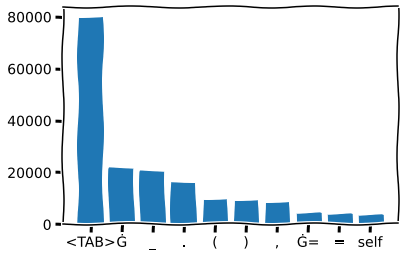

In [ ]:
keys, values = zip(*trn_complex_tokens.most_common(10))
plt.bar([tokenizer.convert_ids_to_tokens(k) for k in keys], values)
plt.show()

In [ ]:
trn_dataset

Dataset({
    features: ['method', 'block', 'complex_masked_block', 'complex_input', 'complex_target', 'medium_masked_block', 'medium_input', 'medium_target', 'simple_masked_block', 'simple_input', 'simple_target'],
    num_rows: 579941
})

In [ ]:
for row in trn_dataset.select(range(10)):
    print(row["simple_target"])
    # tokens.update(row["input_ids"])

e: <TAB><TAB><TAB>logging.error(e)
<TAB><TAB><TAB><TAB><TAB>self.range.add(i) <TAB><TAB><TAB><TAB><TAB>i += 1
<TAB><TAB><TAB>is_strict=True, <TAB><TAB>)
<TAB><TAB><TAB>batch_size=params.train.batch_size, <TAB><TAB>)
<TAB><TAB><TAB>num_examples=params.eval.eval_samples, <TAB><TAB>)
<TAB><TAB><TAB><TAB>log_steps=FLAGS.log_steps, <TAB><TAB><TAB>) <TAB><TAB>)
<TAB><TAB><TAB>return violations.D210()
"libc": <TAB><TAB><TAB>plat = "android"
error_format=ARMErrorFormat <TAB><TAB>)
<TAB><TAB>dest_password = input.get("dest_password")


In [ ]:
tst_dataset

Dataset({
    features: ['method', 'block', 'complex_masked_block', 'complex_input', 'complex_target', 'medium_masked_block', 'medium_input', 'medium_target', 'simple_masked_block', 'simple_input', 'simple_target'],
    num_rows: 72431
})

In [ ]:
idx = 0
print(tst_dataset["method"][idx])

def can_edit_general_settings_or_raise(handler):
<TAB>"""Determines if this user has ACL permissions to edit general settings"""
<TAB>if handler.current_user.user_role == "admin":
<TAB><TAB>returnValue(True)
<TAB>else:
<TAB><TAB># Get the full user so we can see what we can access
<TAB><TAB>user = yield get_user(
<TAB><TAB><TAB>handler.current_user.user_tid,
<TAB><TAB><TAB>handler.current_user.user_id,
<TAB><TAB><TAB>handler.request.language,
<TAB><TAB>)
<TAB><TAB>if user["can_edit_general_settings"] is True:
<TAB><TAB><TAB>returnValue(True)
<TAB>raise errors.InvalidAuthentication



In [ ]:
print(tst_dataset["block"][idx])

<TAB><TAB>user = yield get_user(
<TAB><TAB><TAB>handler.current_user.user_tid,
<TAB><TAB><TAB>handler.current_user.user_id,
<TAB><TAB><TAB>handler.request.language,
<TAB><TAB>)
<TAB><TAB>if user["can_edit_general_settings"] is True:
<TAB><TAB><TAB>returnValue(True)


In [ ]:
print(tst_dataset["simple_masked_block"][idx])

<TAB><TAB>user = yield get_user(
<TAB><TAB><TAB>handler.current_user.user_tid,
<TAB><TAB><TAB>handler.current_user.user_id,
<TAB><TAB><TAB>handler.request.language,
<TAB><TAB>)
<TAB><TAB>if user["can_edit_general_settings"]<MASK>


In [ ]:
print(tst_dataset["simple_input"][idx])

def can_edit_general_settings_or_raise(handler): <TAB>"""Determines if this user has ACL permissions to edit general settings""" <TAB>if handler.current_user.user_role == "admin": <TAB><TAB>returnValue(True) <TAB>else: <TAB><TAB># Get the full user so we can see what we can access <TAB><TAB>user = yield get_user( <TAB><TAB><TAB>handler.current_user.user_tid, <TAB><TAB><TAB>handler.current_user.user_id, <TAB><TAB><TAB>handler.request.language, <TAB><TAB>) <TAB><TAB>if user["can_edit_general_settings"]<MASK> <TAB>raise errors.InvalidAuthentication 


In [ ]:
print(tst_dataset["simple_target"][idx])

is True: <TAB><TAB><TAB>returnValue(True)


In [ ]:
checkpoint_path = "/home/jovyan/data/output/simple-wo-alibi/checkpoints/completeformer-epoch=04-val_loss=0.88.ckpt"
simple_model = Completeformer.load_from_checkpoint(checkpoint_path)

In [ ]:
texts = [tst_dataset["simple_input"][idx], tst_dataset["simple_input"][idx + 1]]
batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
batch["labels"] = tokenizer([tst_dataset["simple_target"][idx], tst_dataset["simple_target"][idx + 1]], return_tensors="pt", padding=True, truncation=True)["input_ids"]

device = "cuda"
simple_model = simple_model.to(device)
srcs = batch["input_ids"].to(device)
srcs_mask = batch["attention_mask"].bool().to(device)
tgts = batch["labels"].to(device)
tgts_mask = tgts != tokenizer.pad_token_id

In [ ]:
tgts_mask.shape

torch.Size([2, 12])

In [ ]:
num_tokens = torch.max(tgts_mask.sum(dim=1)); num_tokens

tensor(12, device='cuda:0')

In [ ]:
num_tokens = tgts_mask.sum(dim=1)
max_tokens = torch.max(num_tokens).item()
start_tokens = (torch.ones((2, 1)) * tokenizer.bos_token_id).long().to(device)

In [ ]:
samples = simple_model.model.generate(srcs, start_tokens, max_tokens, src_mask=srcs_mask, filter_logits_fn=top_p)#.cpu().numpy()
new_samples, new_tgts = [], []
for i in range(0, num_tokens.shape[0]):
    new_samples.append(samples[i][:num_tokens[i].item()].tolist())
    new_tgts.append(tgts[i][:num_tokens[i].item()].tolist())
decoded_preds = tokenizer.batch_decode(new_samples, skip_special_tokens=False)
decoded_labels = tokenizer.batch_decode(new_tgts, skip_special_tokens=False)

In [ ]:
new_samples

[[29218, 277, 2252, 402, 221, 50004, 50004, 50004, 1029, 752, 8, 571],
 [50004, 50004, 50004, 2408, 413, 262, 286, 2603, 392, 261, 1868]]

In [ ]:
new_tgts

[[347, 615, 26, 221, 50004, 50004, 50004, 1029, 752, 8, 571, 9],
 [50004, 50004, 50004, 2408, 413, 262, 286, 2603, 392, 261, 1550]]

In [ ]:
decoded_preds

['!= "edit": <TAB><TAB><TAB>returnValue(True',
 '<TAB><TAB><TAB>ret["onionservice"] = root']

In [ ]:
decoded_labels

['is True: <TAB><TAB><TAB>returnValue(True)',
 '<TAB><TAB><TAB>ret["onionservice"] = ""']

In [ ]:
text = "def bubbleSort(arr): <TAB>n = len(arr) <TAB># <MASK> <TAB># to go through the entire process"
prediction = simple_model.generate(text, tokenizer)
completion = text.replace("<MASK>", prediction)
prediction

'<TAB><TAB>arr = arr[n:] <TAB><TAB>arr = arr[n:][:] = arr[n:] <TAB><TAB>return arr[arr][:]'